In [1]:
#
# phase1:
#   Gaussian Mixture Model (GMM) distribution approximating
#   normalising flow & mean field
#

%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import network.meanField as mf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import seaborn as sns
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
DIM = 2
SAMPLINGNUM = 30
NUMITER = 10000
ROOT = '../report/figs/gmm/mf/'
ziters = [0,19,49,99,199,999,1999,4999,NUMITER-1]

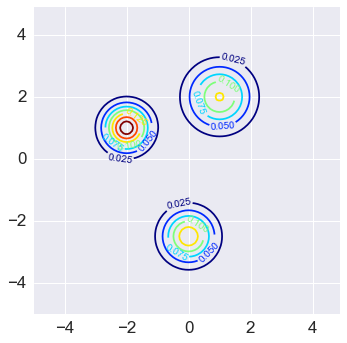

In [4]:
# true p(z)
means   = np.asarray( [[1.0,2.0],[-0.,-2.5],[-2.0,1.0]] )
varmats = np.asarray( [np.eye(2)/2, np.eye(2)/3, np.eye(2)/4] ) 
weights = np.asarray( [0.4,0.3,0.3] )
logTarget = mathT.multiGmm(means, varmats,weights)

# true p(z)
fgmm = mathZ.multiGmmInit(means,varmats,weights)
showvalues = []
gz, g1, g2 = mathZ.gridPoints( (-5,5,0.1), (-5,5,0.1) )
gpz = np.exp( fgmm(gz).reshape(g1.shape[1],g2.shape[0]) )

fig = plt.figure()
CS = plt.contour(g1,g2,gpz,cmap='jet')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig(ROOT+'gmm.png')
plt.show()


In [5]:
# construction variational model
vi = mf.MeanField(DIM)
zs, logqzs = vi.getZ(SAMPLINGNUM)

# setting cost variable
logpzs = logTarget(zs)
cost = T.mean( logqzs - logpzs ) # KL cost

params = vi.getParams()
grads = [ T.grad(cost,p) for p in params ]

In [6]:
# optimisation setup
# iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpzs), T.mean(logqzs) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [7]:
# training
keys = ['cost','pz','qz']
record = {'values':[]}
for k in keys:
    record[k] = []
    
zset = set(ziters)
for i in range(NUMITER):
    out = estep()
    for k,q in enumerate(out):
        record[keys[k]].append( q )
    if i in zset:
        record['values'].append( vi.getParamValues() )
        
for k in keys:
    record[k] = np.asarray( record[k] )
record['iters']=ziters

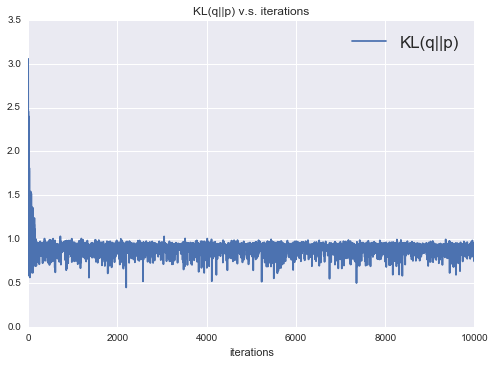

In [8]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)

plt.xlabel('iterations')
plt.title('KL(q||p) v.s. iterations')
plt.plot( xs, record['cost'], '-', label='KL(q||p)')
# plt.plot( xs, record['pz'], '-', label='log-pz')
# plt.plot( xs, record['qz'], '-', label='log-qz')

plt.legend(fontsize=17)


# plt.plot( xs, record['mu'][:,0], '-', label='mean-z0')
# plt.plot( xs, record['mu'][:,1], '-', label='mean-z1')
# plt.legend()
# plt.show()

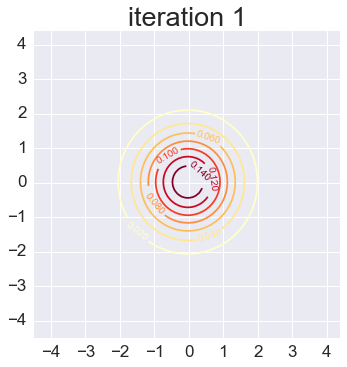

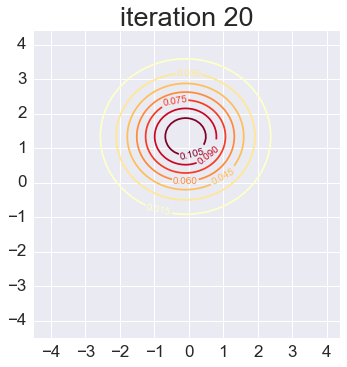

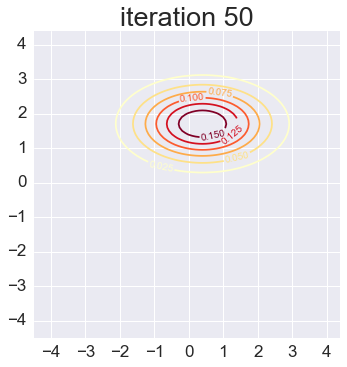

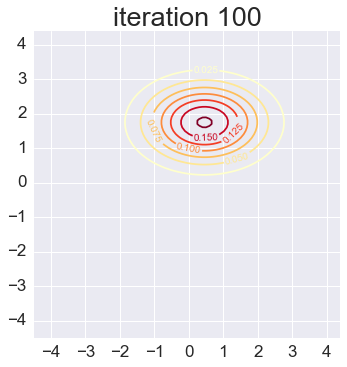

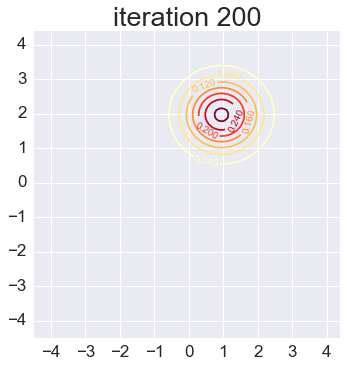

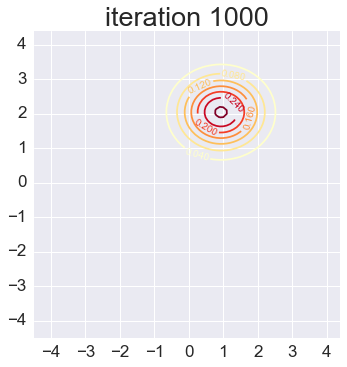

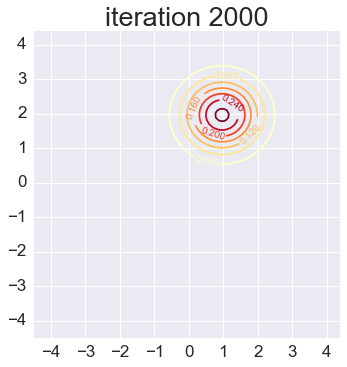

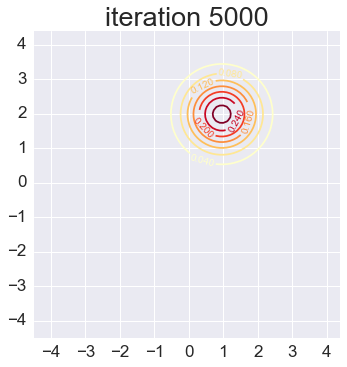

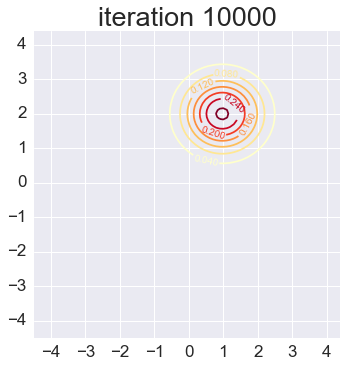

In [33]:
# 

gz, g1, g2 = mathZ.gridPoints( (-4.5,4.5,0.1), (-4.5,4.5,0.1) )
for i, niter in enumerate(record['iters']):
    vi.setParamValues(record['values'][i])
    mflogqz = vi.nlogqz(gz,renew=True)
    gpz = np.exp( mflogqz.reshape(g1.shape[1],g2.shape[0]) )
    CS = plt.contour(g1,g2,gpz, cmap='YlOrRd')
    plt.clabel(CS, inline=1, fontsize=10)
    plt.axes().set_aspect('equal')
    plt.title('iteration %d'%(niter+1),fontsize=27)
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.savefig(ROOT+'mf2_iter%d.png' % (niter+1))
    plt.show()
# xlims = [-4.5,+4.5]
# ylims = [-4.5,+4.5]
# zss, _ = vi.getZ(50000)
# for i, niter in enumerate(record['iters']):
#     vi.setParamValues(record['values'][i])
#     z2 = zss.eval()
#     print np.mean(z2,axis=0)
#     htmap, xedges, yedges = np.histogram2d( z2[:,0], z2[:,1], bins=50)
# #     extent = [xedges[0], xedges[1], yedges[0], yedges[1]]
#     extent = [xlims[0], xlims[1], ylims[0], ylims[1]]
#     plt.figure()
#     plt.imshow(htmap.T, extent=extent, origin='lower', cmap='jet')
#     plt.title('iteration %d' % (niter+1), fontsize=27)
#     plt.tick_params(axis='both', which='major', labelsize=17)
#     plt.savefig(ROOT+'mf2_iter%d.png' % (niter+1))



In [10]:
print record.keys()
print len( record['values'] )

['pz', 'iters', 'cost', 'values', 'qz']
9


In [ ]:
# saving record
SAVEPATH = FIG_PATH+'/record_L%d.npz'%NUM_LAYERS
np.savez(SAVEPATH,cost=record['cost'],zs=record['zs'],numiter=NUMITER,iters=ziters,numlayers=NUM_LAYERS)
print 'record saved to %s' % SAVEPATH